In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation
from scipy.sparse        import diags_array
from scipy.sparse.linalg import spsolve
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))
display(HTML(""" <style>.output_png { display: table-cell; text-align: center; vertical-align: middle; }</style> """))
display(HTML("<style> div.text_cell_render { line-height: 2.0; } </style>"))    # Adjust linespread

In [ ]:
def plotting(U, x, t, exact_handle):
    # grid spacing
    dx = x[1] - x[0]

    markers = ['x','s','d','+','o','.']
    colours = ['xkcd:salmon','xkcd:golden rod','xkcd:teal',
               'xkcd:purple','xkcd:slate','xkcd:silver']
    disp_times = [1, N//20, N//10, N//5, N//2, N]

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.scatter([0], [0], color='white', label=r'Exact $u(x,t)$', lw=0)
    for i, idx_t in enumerate(disp_times):
        lbl = ('t = {0:.0e}'.format(t[idx_t])
               if 0 < t[idx_t] < T else
               't = {0:.0f}'.format(t[idx_t]))
        ax.plot(x, exact_handle(x, t[idx_t]),
                color=colours[i], label=lbl)

    ax.scatter([0], [0], color='white',
               label=r'Numerical $U(x,t)$', lw=0)
    for i, idx_t in enumerate(disp_times):
        lbl = ('t = {0:.0e}'.format(t[idx_t])
               if 0 < t[idx_t] < T else
               't = {0:.0f}'.format(t[idx_t]))
        ax.plot(x[::2], U[idx_t][::2],
                linestyle='', marker=markers[i],
                color=colours[i], label=lbl)

    ax.legend(ncols=2, loc='center',
              bbox_to_anchor=(1.2, 0.5), title='Comparison')
    # show full domain
    ax.set_xlim(x.min() - dx, x.max() + dx)
    # show a line at x = 0.25
    ax.axvline(x=0.25, color='gray', linestyle='--', lw=1)

    plt.xlabel("Space (x)")
    plt.ylabel("Solution")
    plt.show()

In [ ]:
# --- Now we want to implement the screen ---

# To do this we need to model the screen to the right and left (assuming our screen starts to the right x0)
# On the right we replicate the toy model but with right boundary condition u_x(screen, t)=0.01 (or some small number)
# On the left of the screen we need to solve the diffusion equation again but wiht the initial condition of x_0=0
# and have boundary conditions of u_x(screen, t)=-0.01 such that is the negative of the right side of the screen,
# and have a zero BC at the end of the room L

# --- To investigate further ---

# The use of a function of x,t as the boudnary condition at the screen
# Implementation of advection to the model 

CFL number: 2.0000 (should be ≤ 0.5 for stability)


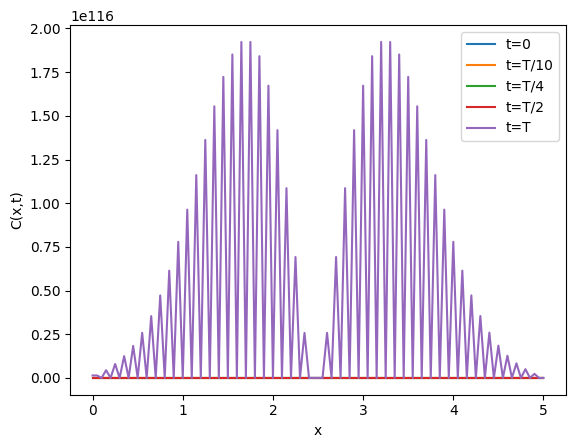

In [ ]:
# ** Toy Model inital contion and exact solution ** #
def D(x):
    D_air = 1.0
    D_screen = 0.01
    x_screen = 2.5
    D = np.zeros_like(x)
    mask = np.abs(x - x_screen) <= 0.1
    D[mask] = D_screen
    D[~mask] = D_air
    return D


def f(x):
    x0 = x[len(x)//2]
    epsilon = 0.05 
    
    U0 = np.zeros_like(x)
    mask = np.abs(x - x0) <= epsilon
    U0[mask] = 1 / (2 * epsilon) 
    return U0

# Couldn't find an analytic solution

N = 200      # number of timesteps
T = 1        # final time 
t = np.linspace(0, T, 201)      # Time grid
M = 100      #
x = np.linspace(0, 5, M + 1)

dx = x[1] - x[0] 
dt = t[1] - t[0]

C = dt/(dx**2)

x_screen = np.linspace(2.4,2.6,5)

dx = x[1] - x[0] 
dt = t[1] - t[0]

C = dt/(dx**2)


# ------------------------------------------------------ #
# Trying to implement the new Neumann BCs at the screen
# ------------------------------------------------------ #


# P = 1
diags = np.ones((3,M+1))
diags[0] += 2 * C             
diags[1:] = - C;    

# # APPLY SCREEN MODIFICATION
# reduction_factor = (1 - P) 

# # Upper diagonal (Flux from k+1 to k, at index k of diags[1])
# # diags[1] corresponds to the 1 offset (upper diagonal)
# diags[1, k] *= reduction_factor

# # Lower diagonal (Flux from k to k+1, at index k+1 of diags[2])
# # diags[2] corresponds to the -1 offset (lower diagonal)
# diags[2, k+1] *= reduction_factor

# ... (Your original boundary fixes: diags[1,0] and diags[2,-2])
diags[1,0] = - 2*C
diags[2,-2] = -2*C

# Create the matrix
A = diags_array(diags, offsets = (0,1,-1), shape = (M+1, M+1), format = 'csr')

#------------------------------------------------------- #

# Initialize solution array
U = np.zeros((len(t), len(x)))
U[0, :] = f(x)

# Compute D at grid points
D_vals = D(x)

# Compute D at cell interfaces (midpoints)
D_interfaces = 0.5 * (D_vals[:-1] + D_vals[1:])

# Check CFL condition
D_max = np.max(D_vals)
CFL = D_max * dt / dx**2

# Better boundary conditions (zero flux/reflective)
for n in range(len(t) - 1):
    U_new = U[n, :].copy()
    
    for i in range(1, len(x) - 1):
        flux_right = D_interfaces[i] * (U[n, i+1] - U[n, i]) / dx
        flux_left = D_interfaces[i-1] * (U[n, i] - U[n, i-1]) / dx
        U_new[i] = U[n, i] + (dt / dx) * (flux_right - flux_left)
    
    # Zero flux boundary conditions (no flow out)
    U_new[0] = U_new[1]
    U_new[-1] = U_new[-2]
    
    # Enforce non-negativity as safety check
    U_new = np.maximum(U_new, 0)
    
    U[n+1, :] = U_new


plt.plot(x, U[1], label='t=0')
plt.plot(x, U[N//10], label='t=T/10')
plt.plot(x, U[N//4], label='t=T/4')
plt.plot(x, U[N//2], label='t=T/2')
plt.plot(x, U[N], label='t=T')
#plt.axvline(x=x_screen, color='gray', linestyle='--', lw=1, label='Screen Position')
plt.xlabel('x')
plt.ylabel('C(x,t)')
#plt.title('Diffusion with Screen at x={}'.format(x_screen))
plt.legend()
plt.show()

In [ ]:
# Now we simulate what happens on the other side of the screen

def f_new(x):
    return np.zeros_like(x)

N = 200      # number of timesteps
T = 1        # final time 
t = np.linspace(0, T, 201)      # Time grid
M = 100      #
x = np.linspace(x_screen, 2, M + 1)

dx = x[1] - x[0] 
dt = t[1] - t[0]

C = dt/(dx**2)

x_screen = 0.25
k = np.argmin(np.abs(x - x_screen))

dx = x[1] - x[0] 
dt = t[1] - t[0]

C = dt/(dx**2)